# Intro
Notebook uses BW generated portfolios of different timeframes. Generates a dataframe of historical OHLCV for portfolio analysis and backtesting.

BW portfolios consists of csv files with symbols as csv data and the utc timestamps as the filenames


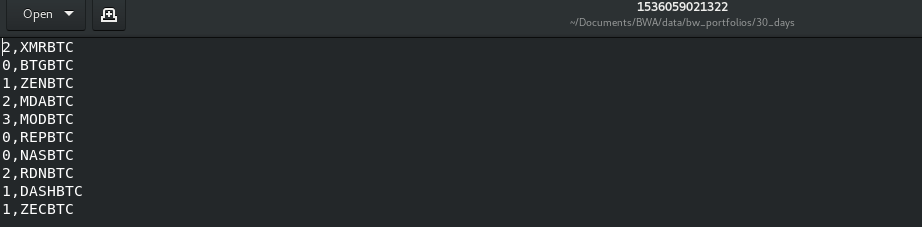

In [1]:
from IPython.display import Image
from IPython.display import display, HTML
Image("/home/me/Pictures/port_exx.png")


# Imports

In [2]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
import random, timeit
import pprint
#statistics imports
import ffn
#backtest import
import bt
#binance api import
from binance.client import Client

#add your api keys here
api_key = 'XuozVlFg2WYVemwmHMqCK9j5jSYIV1z3MoDAXY76X2JiCbbgcw7dGxvE0eGVsqhH'
secret_key = 'WyWBCdczLCFvV8fKy16R5dOwhhjK31T7ZrW0cplIzjrvmlSPh5E1KEeAEh5c9I6s'

#initialize binance client
client = Client(api_key, secret_key)

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

### Functions to read and create portfolios

In [3]:


def read_portfolios(tf):
    """
    Reads portfolio folders and
    gets symbols for historical data
    """
    #load portfolio folder files
    tf = str(tf) + "_days"
    port_loc = "/home/me/Documents/BWA/data/bw_portfolios/"
    #Exit loop if invalid timeframe
    if not os.path.exists(port_loc+tf):
        print("Timeframe invalid try: {}".format(os.listdir(port_loc)))
        return 0
    port_loc = port_loc+tf
    port_files = os.listdir(port_loc)
    ps = str(len(port_files))
    
    #sort portfolio
    port_files.sort()
    
    print("Found {} portfolios...".format(ps))
    #print(port_files[0:5])
    all_port = {}
    for t in port_files:
        data = pd.read_csv(port_loc+"/"+t)
        data.columns = ['i','sym']
        data = data[['sym']].copy()
        
        #data = data.values
        data = data['sym'].append(pd.DataFrame(['BTCUSDT']))
        #print(data)
        
        
        #print('i',str(len(data)),'sym','BTCUSDT')
        
        #print(data)
        all_port[t] = data
        #print(data)
    return all_port

def check_merge():
    pass

def get_data(sym,prev_k,k,candle_k=5):
    prev_k = str(prev_k)
    k = str(k)
    #print("Before",prev_k,k)
    #fix to get data from selected timeframe
    
    #print("After",prev_k,k)
    data = client.get_historical_klines(sym,interval= str(candle_k)+'m',start_str =int(prev_k),end_str = int(k))
    #print(data)
    data = pd.DataFrame(data,columns=['Open time','Open','High','Low','Close','Volume','Close time','Quote volume','Num trades', 'btc buys', 'coin buys', 'ignore'])
    #data = data.fillna(method='ffill')
    # convert from millesecond time to datetime for potential resampling and readability
    data['Open time'] = data['Open time']/1000
    data['Open time'] = data['Open time'].astype('datetime64[s]')
    data = data.set_index('Open time')
    data = data[['Open','High','Low','Close','Close time','Volume']].astype(float)
    return data

def create_hist_port(port_dict):
    """
    Function creates continuous dataset for BW portfolio for ARIMA model/backtesting
    Merges dataset between portfolio timestamps
    """
    hist_port = []
    #check full length of port hist dataset and current time
    current_milli_time = lambda: int(round(time.time() * 1000))
    now = current_milli_time()
    times = list(port_dict.keys())
    ttd = now-int(times[0])
    candle_k = 15 
    print("Total timedelta: ",ttd)
    print("Portfolio start:{} end:{}".format(datetime.datetime.fromtimestamp(int(times[0])/1000),datetime.datetime.fromtimestamp(now/1000)))
    #loop through portfolio dictionary and download hist data for each sym
    prev_k = 0
    ct = 0
    idex = []
    for k,v in port_dict.items():
        #print(prev_k,k)
        k = int(k)
        #first iteration has start but no endpoint
        
        if ct == len(times):
            break
        if prev_k == 0:
            prev_k = k
            k=int(times[1])
            ct+=1
        
            
         
        if candle_k == 5:
            prev_k = str(prev_k)
            print(ct)
            if ct == len(times)-1:
                k = str(now)
            else:
                ct+=1
                k = times[ct]
            #pseudo rounding to last kline
            print(prev_k,k)
            prev_k = prev_k[:-5]
            prev_k+='99999'
            prev_k = int(prev_k)
            #same for k
            k = k[:-5]
            k+='99999'
            k = int(k)
            
        if candle_k == 15:
            prev_k = str(prev_k)
            print(ct)
            if ct == len(times)-1:
                k = str(now)
            else:
                ct+=1
                k = times[ct]
            #pseudo rounding to last kline
            prev_k = prev_k[:-5]
            prev_k+='99999'
            prev_k = int(prev_k)
            #same for k
            k = k[:-5]
            k+='99999'
            k = int(k)
        start = datetime.datetime.fromtimestamp(prev_k/1000)
        end = datetime.datetime.fromtimestamp(k/1000)
        if (prev_k == k):
            break
        
        print('Start:{} End:{}'.format(start,end))
        
        port_data = {}
        #print(v)
        for sym in v[0]:
            data = None
            sym = sym.replace(" ","")
            #continuously try to get sym data
            while data is None:
                try:

                    data = get_data(sym,prev_k,k,candle_k)
                except Exception as e:
                    print(e)
            
                
            print("Downloaded...:",sym)
            # dict keys: syms values: hist data
            #print(len(data))
        
            port_data[sym] = data
            idex = data['Close time']
        #dict keys: start time values: portfolio dict
        
        hist_port.append(port_data)
        prev_k = k
        
        #print(hist_port[prev_k])
    
    return hist_port



In [4]:
#Create dictionary of portfolios and timestamps for getting hist. data
tf = input("Enter freq timeframe:")

port_dict = read_portfolios(tf)
hist_port = create_hist_port(port_dict)

Enter freq timeframe:30
Found 5 portfolios...
Total timedelta:  10867396821
Portfolio start:2018-08-24 00:09:22.289000 end:2018-12-27 17:52:39.110000
1
Start:2018-08-24 00:09:59.999000 End:2018-09-23 00:09:59.999000
Downloaded...: ENGBTC
Downloaded...: BTCUSDT
2
Start:2018-09-23 00:09:59.999000 End:2018-10-23 00:09:59.999000
Downloaded...: BTGBTC
Downloaded...: ZENBTC
Downloaded...: MDABTC
Downloaded...: MODBTC
Downloaded...: REPBTC
Downloaded...: NASBTC
Downloaded...: RDNBTC
Downloaded...: DASHBTC
Downloaded...: ZECBTC
Downloaded...: BTCUSDT
3
Start:2018-10-23 00:09:59.999000 End:2018-11-21 23:09:59.999000
Downloaded...: MODBTC
Downloaded...: SNMBTC
Downloaded...: XMRBTC
Downloaded...: KMDBTC
Downloaded...: AEBTC
Downloaded...: DNTBTC
Downloaded...: NASBTC
Downloaded...: ZENBTC
Downloaded...: WAVESBTC
Downloaded...: BTCUSDT
4
Start:2018-11-21 23:09:59.999000 End:2018-12-27 17:53:19.999000
HTTPSConnectionPool(host='api.binance.com', port=443): Read timed out. (read timeout=10)
Download

# Portfolio Analytics using FFN:

Gets statistical data for each period of the portfolio
-plots equity, log returns, and drawdown
-calculate  weights at halfway timestamp for analysis
-plots simple clustering



Portfolio from 2018-08-24 04:30:00 to 2018-09-23 04:00:00
Created weights at:2018-09-08 04:15:00
BTCUSDT    70.01%
ENGBTC     29.99%
Name: erc, dtype: object
Stat                 BTCUSDT     ENGBTC
-------------------  ----------  ----------
Start                2018-08-24  2018-08-24
End                  2018-09-23  2018-09-23
Risk-free rate       0.00%       0.00%

Total Return         3.45%       -10.58%
Daily Sharpe         0.31        -1.21
Daily Sortino        0.42        -2.11
CAGR                 7.06%       -87.40%
Max Drawdown         -15.95%     -36.02%
Calmar Ratio         0.44        -2.43

MTD                  -4.16%      -26.60%
3m                   -           -
6m                   -           -
YTD                  3.45%       -10.58%
1Y                   -           -
3Y (ann.)            -           -
5Y (ann.)            -           -
10Y (ann.)           -           -
Since Incep. (ann.)  7.06%       -87.40%

Daily Sharpe         0.31        -1.21
Daily Sortino 

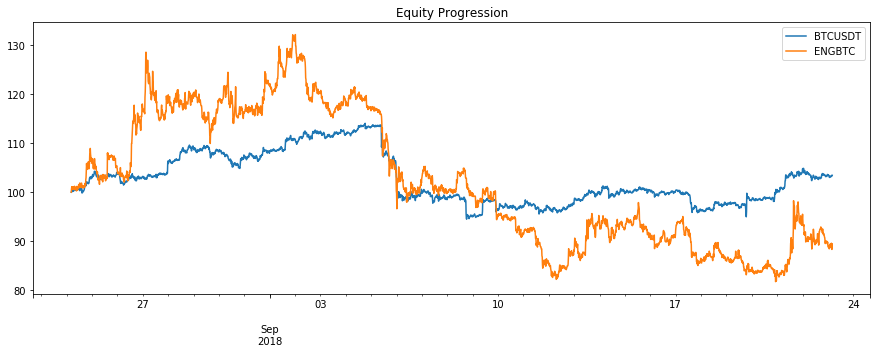

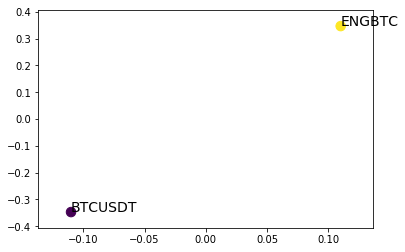

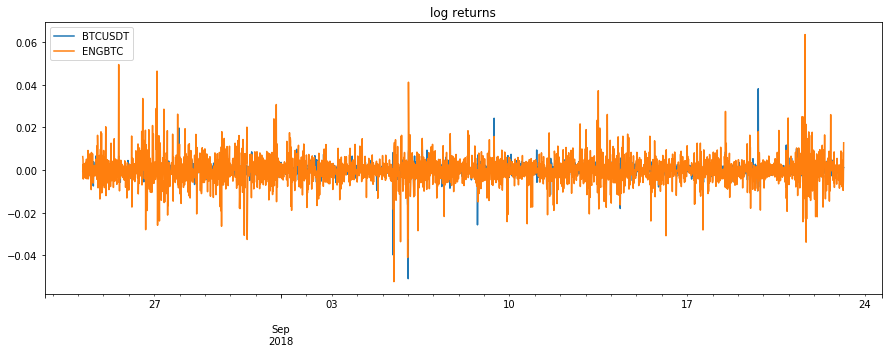

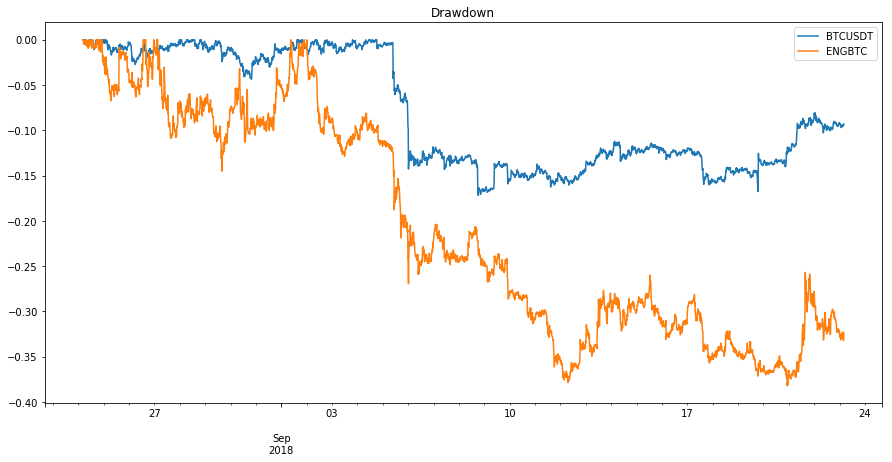



Portfolio from 2018-09-23 04:30:00 to 2018-10-23 04:00:00
Created weights at:2018-10-08 02:30:00
BTCUSDT    15.56%
BTGBTC     11.46%
DASHBTC    14.46%
MDABTC      5.29%
MODBTC      7.28%
NASBTC      8.11%
RDNBTC      6.87%
REPBTC     10.65%
ZECBTC     10.10%
ZENBTC     10.23%
Name: erc, dtype: object
Stat                 BTCUSDT     BTGBTC      DASHBTC     MDABTC         MODBTC      NASBTC      RDNBTC      REPBTC      ZECBTC      ZENBTC
-------------------  ----------  ----------  ----------  -------------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2018-09-23  2018-09-23  2018-09-23  2018-09-23     2018-09-23  2018-09-23  2018-09-23  2018-09-23  2018-09-23  2018-09-23
End                  2018-10-23  2018-10-23  2018-10-23  2018-10-23     2018-10-23  2018-10-23  2018-10-23  2018-10-23  2018-10-23  2018-10-23
Risk-free rate       0.00%       0.00%       0.00%       0.00%          0.00%       0.00%       0.00%       0.00%       0.00%   

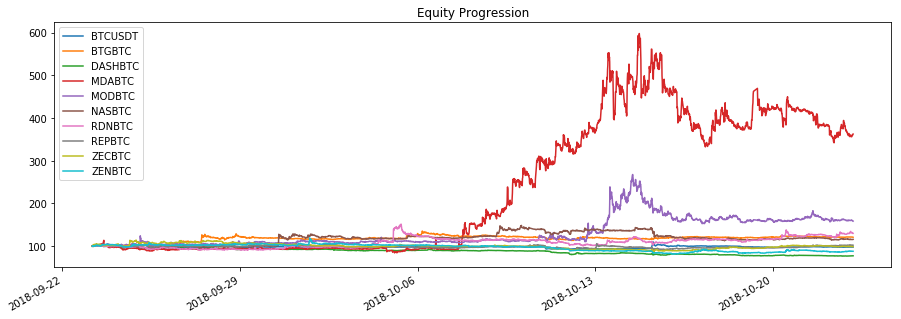

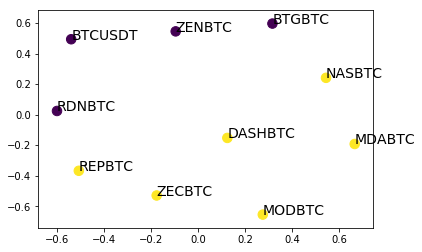

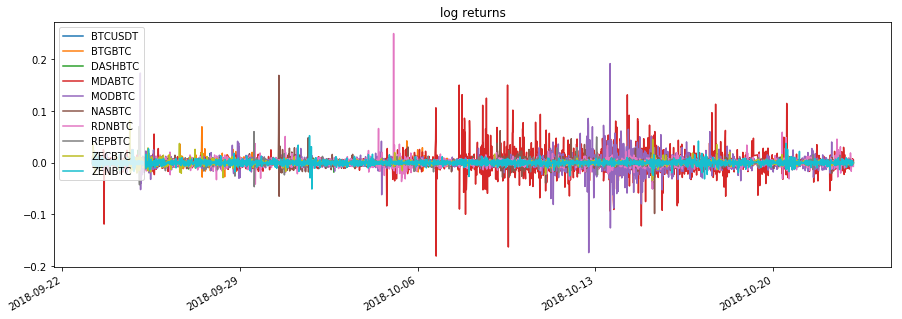

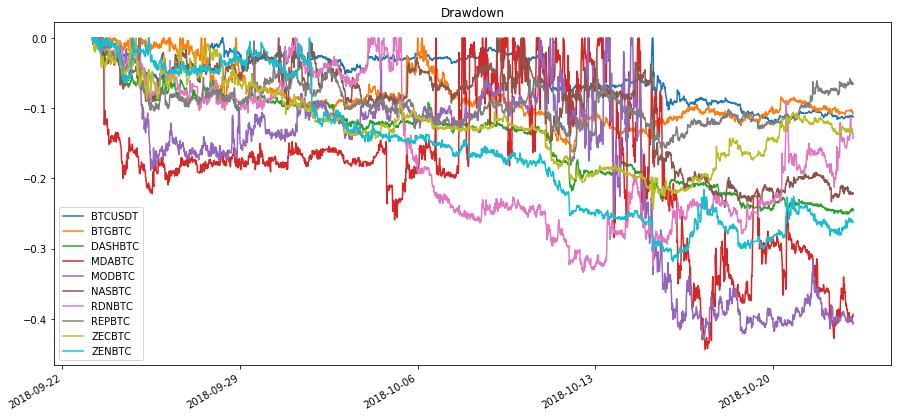



Portfolio from 2018-10-23 04:30:00 to 2018-11-22 04:00:00
Created weights at:2018-11-07 00:45:00
AEBTC       10.61%
BTCUSDT     20.64%
DNTBTC       4.53%
KMDBTC      10.13%
MODBTC       6.55%
NASBTC      10.44%
SNMBTC       5.19%
WAVESBTC    10.51%
XMRBTC      15.65%
ZENBTC       5.76%
Name: erc, dtype: object
Stat                 AEBTC       BTCUSDT     DNTBTC      KMDBTC      MODBTC      NASBTC      SNMBTC      WAVESBTC    XMRBTC      ZENBTC
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2018-10-23  2018-10-23  2018-10-23  2018-10-23  2018-10-23  2018-10-23  2018-10-23  2018-10-23  2018-10-23  2018-10-23
End                  2018-11-22  2018-11-22  2018-11-22  2018-11-22  2018-11-22  2018-11-22  2018-11-22  2018-11-22  2018-11-22  2018-11-22
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0

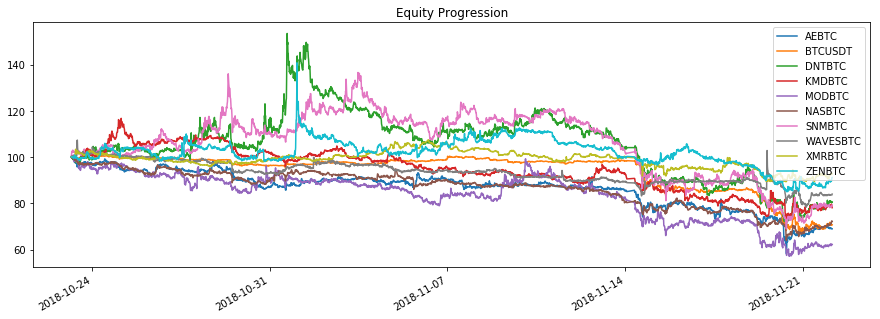

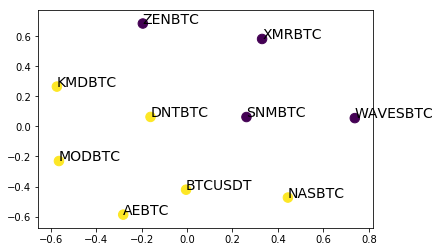

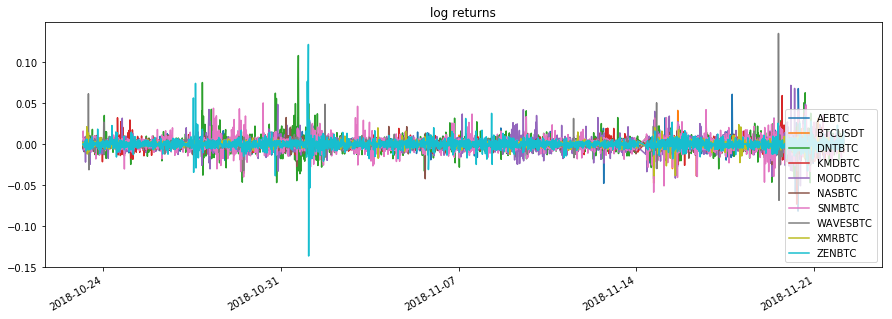

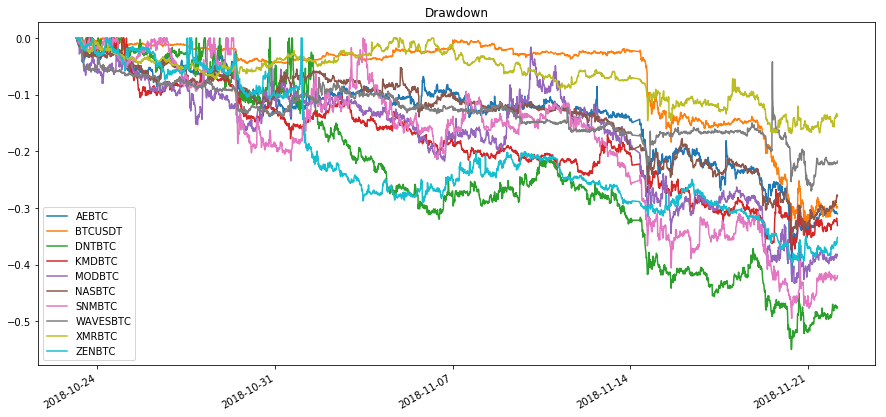



Portfolio from 2018-11-22 04:30:00 to 2018-12-27 22:45:00
Created weights at:2018-12-10 01:45:00
BQXBTC      7.80%
BTCUSDT    10.08%
BTGBTC     11.47%
DASHBTC    14.12%
DGDBTC     10.56%
KMDBTC      8.07%
NASBTC     10.39%
NULSBTC    11.33%
NXSBTC      5.17%
ZENBTC     10.99%
Name: erc, dtype: object
Stat                 BQXBTC      BTCUSDT     BTGBTC      DASHBTC     DGDBTC      KMDBTC      NASBTC      NULSBTC     NXSBTC      ZENBTC
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2018-11-22  2018-11-22  2018-11-22  2018-11-22  2018-11-22  2018-11-22  2018-11-22  2018-11-22  2018-11-22  2018-11-22
End                  2018-12-27  2018-12-27  2018-12-27  2018-12-27  2018-12-27  2018-12-27  2018-12-27  2018-12-27  2018-12-27  2018-12-27
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Tota

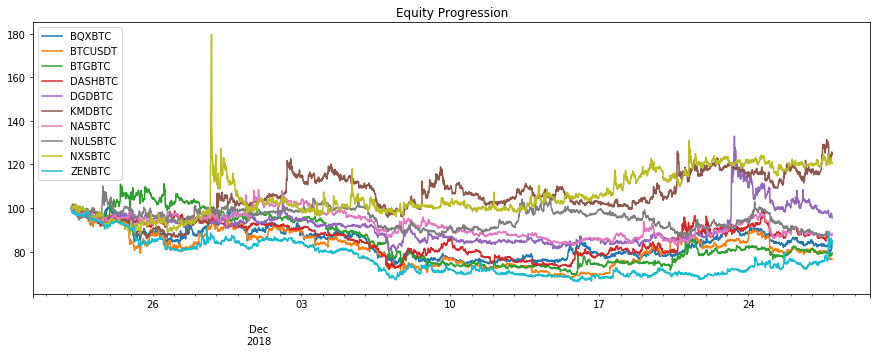

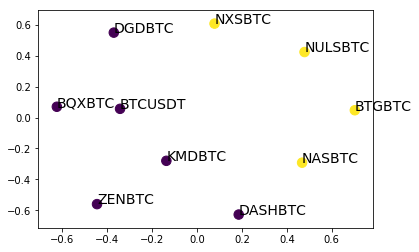

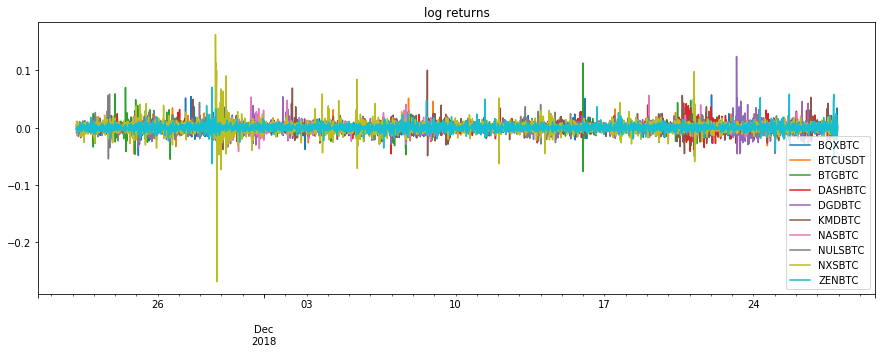

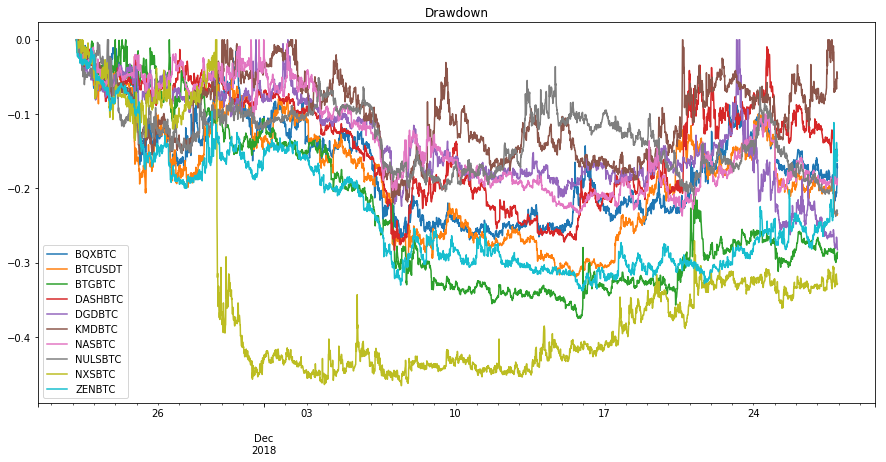

In [5]:
#print(type(hist_port[1]))
#loop through all portfolios
c=0
total_returns = []
for port in hist_port:
    c+=1
    #dict of current portfolio close price
    curr = {}
    idex = []
    #total_perf = None
    #loop through single portfolio's syms and data
    for sym in port:
        #Call functions for feature engineering and backtestin
        #create dataset for ML
        close = port[sym]['Close']
        curr[sym] = close
        idex = port[sym].index.tolist()
        
    #create portfolio dataframe
    port = pd.DataFrame(curr, index = idex)
    
    #get logarithmic returns
    returns = port.to_log_returns().dropna()
    
    #print separator
    print("\n=================================================== \n")
    print("Portfolio from {} to {}".format(returns.index[0],returns.index[-1]))
   
    #testing index selection for weights
    mid = returns.index.tolist()
    mid = mid[int(len(returns)/2)]
    print("Created weights at:{}".format(mid))
    #test print weights at half point
    min_vol_w = returns[:int(len(returns)/2)].calc_mean_var_weights().as_format('.2%')
    erc_w = returns[:int(len(returns)/2)].calc_erc_weights().as_format('.2%')
    inv_vol_w = returns[:int(len(returns)/2)].calc_inv_vol_weights().as_format('.2%')
    pprint.pprint(erc_w)#,erc_w,inv_vol_w)
    #ws = [min_vol_w,erc_w,inv_vol_w]
    #ws = pd.DataFrame(ws,columns=['min_vol','erc','inv_vol'])
    #print(ws)
    total_returns.append(returns)
    #print(returns.head())
    
    
    #calculate performance stats
    perf = ffn.calc_stats(port)
    #group_perf = ffn.GroupStats(port)
    perf.display()
    #btc benchmark
    bench = returns.BTCUSDT
    #print(type(perf.display()))
    
    #Visulaizations
    #plot all
    perf.plot()
    #use cluster as binary classifier for syms similar to btc
    try:
        ffn.core.calc_clusters(returns, n=2, plot=True)
    except:
        ffn.core.calc_clusters(returns, n=None, plot=True)
    #plot log returns
    ax = returns.plot(figsize=(15,5), title='log returns')
    
    #plot max drawdown period
    ax2 = perf.prices.to_drawdown_series().plot(figsize=(15,7),title='Drawdown')
    plt.show()
    perf.to_csv(path='/home/me/Documents/BWA/portfolios/{}-{}'.format(tf,c))